In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from os import path
from linear_opt.lin_metabolism import LinearMetabolicModel

from SALib import ProblemSpec

In [2]:
model_dir = '../models/linear/respiration/'
m_fname = path.join(model_dir, 'glucose_resp_molecular_props.csv')
S_fname = path.join(model_dir, 'glucose_resp_stoich_matrix.csv')
lam = LinearMetabolicModel.FromFiles(m_fname, S_fname)
lam.print_model()

Metabolites:
         NC  NOSC  internal                                               note
C_red     1   0.0         0         reduced C, 1 C of extracellular "glucose" 
C_ox      1   4.0         0                                  oxidized C, "CO2"
E_ox      1   0.0         0  oxidized e- donor/acceptor, O2, has fictional ...
E_red     1  -4.0         0  reduced donor/acceptor, 2 H2O, NC = 1 for bala...
EC       20   0.0         1       Oxidized single e- carrier with 20 carbons. 
ECH      20  -0.1         1  Reduced 2e- carrier, 20*-0.1 => 2 more e- than...
ADP      10   0.0         1                                                ADP
ATP      10   0.0         1                                                ATP
biomass   1   0.0         0                   Everything per C, default ZC = 0
Stoichiometries:
                 C_red  C_ox  E_ox  E_red   EC  ECH  ADP  ATP  biomass  \
process                                                                  
oxidation         -1.0   1.0  0.

In [3]:
# Do a quick run of the model to make sure it is feasible
p = lam.max_anabolic_rate_problem(maint=1e-6, phi_o=0.1)
res = p.solve(verbose=True)
p.value

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Jul 18 12:12:52 PM: Your problem has 4 variables, 2 constraints, and 18 parameters.
(CVXPY) Jul 18 12:12:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 18 12:12:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 18 12:12:52 PM: Compiling problem (target solver=ECOS).
(CVXPY) Jul 18 12:12:52 PM: Reduction chain: EvalParams -> FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Jul 18 12:12:52 PM: Applying reduction EvalParams
(CVXPY) Jul 18 12:12:52 PM: Applying 

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


1.4294117623404052

In [4]:
p = lam.max_anabolic_rate_problem(phi_o=0.4, max_lambda_hr=0.1)
lambdas = np.arange(0.1, 1.501, 0.01)
results = []

for lam_val in lambdas:
    p.param_dict['max_lambda_hr'].value = lam_val
    res = p.solve()
    d = lam.solution_as_dict(p)
    d.update(lam.model_as_dict())
    results.append(d)

phi_df = pd.DataFrame(results)
phi_df['max_lambda_hr'] = lambdas
phi_df.head()

,lambda_hr,max_lambda_hr,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,...,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S6
0,0.10,0.10,0.4,0.086325,0.000043,0.086325,0.000173,0.055556,0.000028,0.371795,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
1,0.11,0.11,0.4,0.085726,0.000043,0.085726,0.000171,0.061111,0.000031,0.367436,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
2,0.12,0.12,0.4,0.085128,0.000043,0.085128,0.000170,0.066667,0.000033,0.363077,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
3,0.13,0.13,0.4,0.084530,0.000042,0.084530,0.000169,0.072222,0.000036,0.358718,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0
4,0.14,0.14,0.4,0.083932,0.000042,0.083932,0.000168,0.077778,0.000039,0.354359,...,200.0,100.0,50.0,100.0,50.0,100.0,0.0,0.0,4.0,0.0


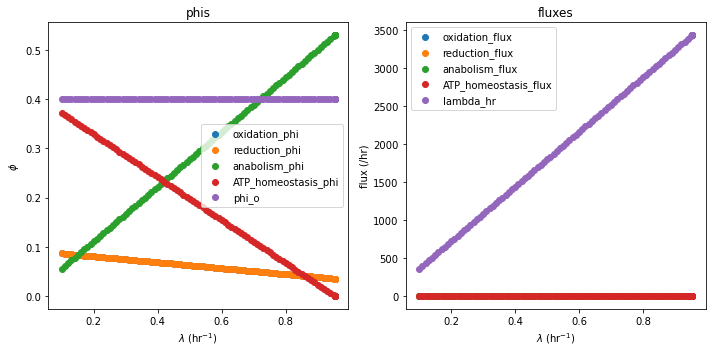

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axs[0])

x = phi_df['lambda_hr']
phi_cols = [c for c in phi_df.columns if c.endswith('phi')] + ['phi_o']
for col in phi_cols:
    plt.scatter(x, phi_df[col], label=col)
plt.title('phis')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'$\phi$')   
plt.legend()

plt.sca(axs[1])
j_cols = [c for c in phi_df.columns if c.endswith('flux')] + ['lambda_hr']
for col in j_cols:
    plt.scatter(x, phi_df[col]*3600, label=col)
plt.title('fluxes')
plt.xlabel(r'$\lambda$ (hr$^{-1}$)')
plt.ylabel(r'flux (/hr)')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# Use the SAlib tools to generate parameters for a sensitivity analysis
ps = ProblemSpec({
        "names": ["phi_o", "S6", "m_resp", "resp_ATP_per_e", "m_ATP_homeostasis"],
        "groups": None,
        "bounds": [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000],],
        "outputs": ["lambda_max"],
    })
ps.sample_sobol(64)

results = []

for phi_o, s6, m_resp, atp_per_e, m_homeo in ps.samples:
    lam.set_S6(s6)
    lam.set_process_mass('reduction', m_resp)
    #lam.set_process_mass('ATP_homeostasis', m_homeo)
    lam.set_ATP_yield('reduction', atp_per_e)
    max_lam, opt_prob = lam.maximize_lambda(phi_o=phi_o)

    d = lam.solution_as_dict(opt_prob)
    d.update(lam.model_as_dict())
    d['resp_ATP_per_e'] = atp_per_e
    results.append(d)

res_df = pd.DataFrame(results)
res_df.head()

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


,lambda_hr,phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,...,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,ZCprod,S6,resp_ATP_per_e
0,0.068401,0.414307,0.0,0.0,0.542743,0.000011,0.038001,0.000019,0.004949,2.474594e-06,...,9501.595240,50.0,100.0,50.0,100.0,0.601268,0.0,4.0,-0.300634,0.715554
1,0.068196,0.416064,0.0,0.0,0.541115,0.000011,0.037887,0.000019,0.004934,2.467170e-06,...,9501.595240,50.0,100.0,50.0,100.0,0.601268,0.0,4.0,-0.300634,0.715554
2,0.092142,0.414307,0.0,0.0,0.533781,0.000011,0.051190,0.000026,0.000722,3.612200e-07,...,9501.595240,50.0,100.0,50.0,100.0,0.438979,0.0,4.0,-0.219489,0.715554
3,0.075304,0.414307,0.0,0.0,0.538409,0.000013,0.041835,0.000021,0.005449,2.724323e-06,...,8561.692607,50.0,100.0,50.0,100.0,0.601268,0.0,4.0,-0.300634,0.715554
4,0.068033,0.414307,0.0,0.0,0.539824,0.000011,0.037796,0.000019,0.008073,4.036258e-06,...,9501.595240,50.0,100.0,50.0,100.0,0.601268,0.0,4.0,-0.300634,0.854162


In [7]:
ps.set_results(res_df.lambda_hr.values)
ps.analyze_sobol(print_to_console=True, calc_second_order=True)

                         ST   ST_conf
phi_o              0.026274  0.011855
S6                 0.291088  0.226199
m_resp             0.731711  0.282122
resp_ATP_per_e     0.173955  0.114300
m_ATP_homeostasis  0.000000  0.000000
                         S1   S1_conf
phi_o              0.018505  0.076441
S6                 0.047611  0.139454
m_resp             0.693621  0.357105
resp_ATP_per_e     0.101329  0.152956
m_ATP_homeostasis  0.000000  0.000000
                                           S2   S2_conf
(phi_o, S6)                          0.027919  0.113383
(phi_o, m_resp)                     -0.023518  0.213964
(phi_o, resp_ATP_per_e)              0.028918  0.117211
(phi_o, m_ATP_homeostasis)           0.014703  0.122046
(S6, m_resp)                         0.251846  0.367204
(S6, resp_ATP_per_e)                 0.151281  0.254857
(S6, m_ATP_homeostasis)              0.060382  0.198029
(m_resp, resp_ATP_per_e)            -0.151488  0.545141
(m_resp, m_ATP_homeostasis)         -0.2

{'names': ['phi_o', 'S6', 'm_resp', 'resp_ATP_per_e', 'm_ATP_homeostasis'],
 'groups': None,
 'bounds': [[0.3, 0.5], [-0.5, 0.5], [10, 10000], [0.2, 2], [10, 10000]],
 'outputs': ['lambda_max'],
 'num_vars': 5,
 'sample_scaled': True}

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

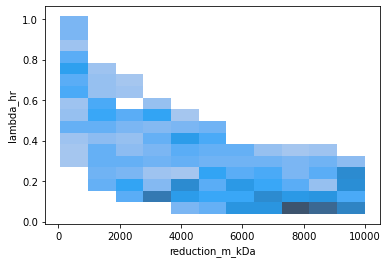

In [8]:
sns.histplot(data=res_df, y='lambda_hr', x='reduction_m_kDa', legend=False)

In [18]:
ZCBs = np.arange(-1, 1.01, 0.05)
phi_os = np.arange(0.1, 0.501, 0.2)
homeo_costs = np.logspace(1, 5, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
results = []
for z in ZCBs:
    for phi_o in phi_os:
        for homeo_cost in homeo_costs:
            for resp_cost in resp_costs:
                for atp_per_e in ATP_per_es:
                    try:
                        ref_lam = lmm.copy()
                        ref_lam.set_ZCB(z)
                        ref_lam.set_process_mass('reduction', resp_cost)
                        ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                        ref_lam.set_ATP_yield('reduction', atp_per_e)
                        m, opt_p = ref_lam.maximize_lambda(min_phi_o=phi_o)

                        d = ref_lam.model_as_dict()
                        d.update(ref_lam.solution_as_dict(opt_p))
                        d['reduction_ATP_per_e'] = atp_per_e
                        results.append(d)
                    except Exception as e:
                        print(e)
                        continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


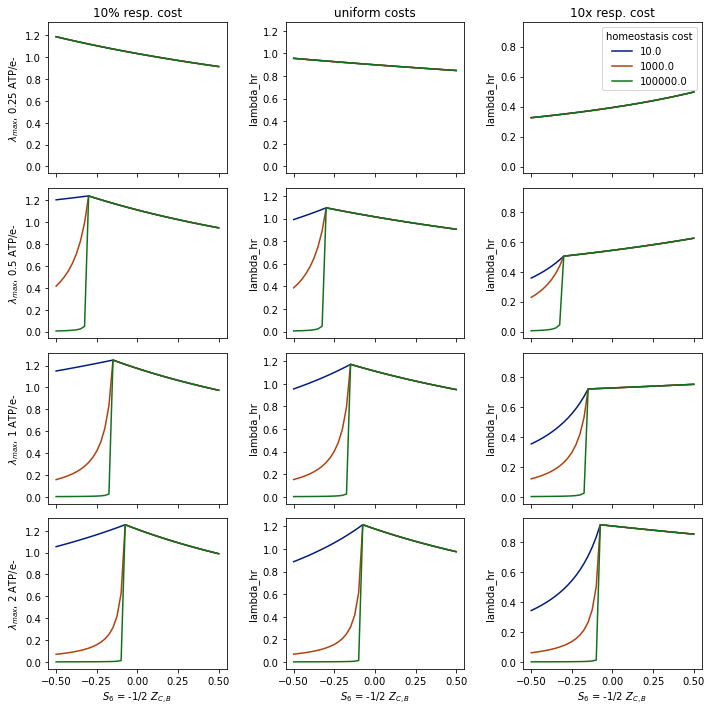

In [19]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', hue='ATP_homeostasis_m_kDa', palette='dark')
        #sns.lineplot(data=res_df[mask], x='S6', y='lambda_hr', palette='dark')
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\lambda_{{max}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend(title='homeostasis cost').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [20]:
res_df.head()

,oxidation_kcat_s,oxidation_m_kDa,reduction_kcat_s,reduction_m_kDa,anabolism_kcat_s,anabolism_m_kDa,ATP_homeostasis_kcat_s,ATP_homeostasis_m_kDa,ZCB,ZCorg,...,min_phi_o,oxidation_phi,oxidation_flux,reduction_phi,reduction_flux,anabolism_phi,anabolism_flux,ATP_homeostasis_phi,ATP_homeostasis_flux,reduction_ATP_per_e
0,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,-1.0,0.0,...,0.1,0.239420,0.000120,0.007618,0.000152,0.652963,0.000326,3.060171e-12,1.530086e-14,0.25
1,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,-1.0,0.0,...,0.1,0.217031,0.000109,0.004748,0.000095,0.678222,0.000339,1.373500e-12,6.867502e-15,0.50
2,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,-1.0,0.0,...,0.1,0.201117,0.000101,0.002707,0.000054,0.696175,0.000348,5.689570e-11,2.844785e-13,1.00
3,50.0,100.0,200.0,10.0,50.0,100.0,50.0,10.0,-1.0,0.0,...,0.1,0.191357,0.000096,0.001456,0.000029,0.707187,0.000354,3.443021e-11,1.721510e-13,2.00
4,50.0,100.0,200.0,100.0,50.0,100.0,50.0,10.0,-1.0,0.0,...,0.1,0.222472,0.000111,0.070787,0.000142,0.606742,0.000303,1.887361e-12,9.436806e-15,0.25


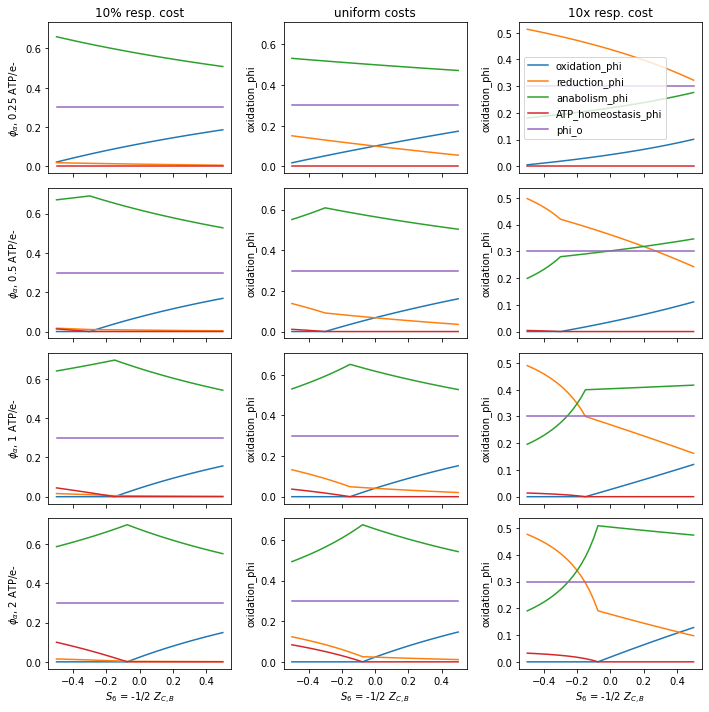

In [23]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex=True, sharey='col')
phi_cols = [c for c in res_df.columns if c.endswith('phi')] + ['phi_o']

titles = '10% resp. cost,uniform costs,10x resp. cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.min_phi_o == phi_os[1])
        mask = np.logical_and(mask, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 10)

        for c in phi_cols:
            sns.lineplot(data=res_df[mask], x='S6', y=c, palette='dark', label=c)
        plt.xlabel('$S_6$ = -1/2 $Z_{C,B}$')
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'$\phi_{{\alpha}}$, {0} ATP/e-'.format(a_per_e))

plt.sca(axs[0,2])
plt.legend().set_visible(True)

plt.tight_layout()
#plt.savefig('../output/lambda_max_vs_S6.png', dpi=300, facecolor='white')
plt.show()

In [12]:
max_lambdas = np.linspace(0.01, 3, 50)
homeo_costs = np.logspace(1, 3, 3)
resp_costs = np.logspace(1, 3, 3)
ATP_per_es = [0.25, 0.5, 1, 2]

lmm = LinearMetabolicModel.FromFiles(m_fname, S_fname)
res_dict = dict(ZCB=[], phi_o=[], homeo_cost=[], lambda_max=[], S6=[], resp_cost=[], resp_ATP_per_e=[])

results = []

for max_lambda in max_lambdas:
    for homeo_cost in homeo_costs:
        for resp_cost in resp_costs:
            for atp_per_e in ATP_per_es:
                try:
                    ref_lam = lmm.copy()
                    ref_lam.set_process_mass('reduction', resp_cost)
                    ref_lam.set_process_mass('ATP_homeostasis', homeo_cost)
                    ref_lam.set_ATP_yield('reduction', atp_per_e)
                    m, opt_p = ref_lam.maximize_lambda(min_phi_o=0.4, max_lambda_hr=max_lambda)

                    d = ref_lam.model_as_dict()
                    d.update(ref_lam.solution_as_dict(opt_p))
                    d['reduction_ATP_per_e'] = atp_per_e
                    results.append(d)
                except:
                    continue
res_df = pd.DataFrame(results)

/opt/miniconda3/lib/python3.8/site-packages/cvxpy/reductions/solvers/solving_chain.py:178: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


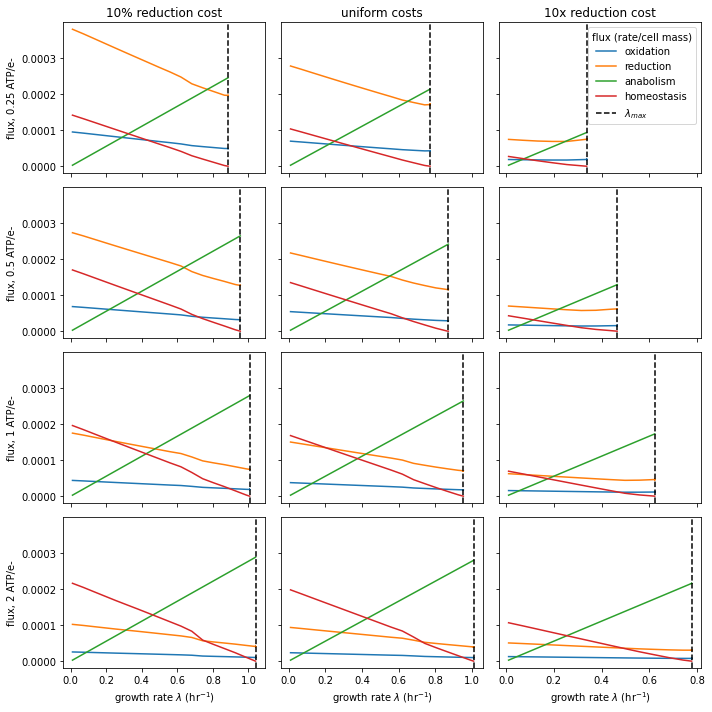

In [13]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=4, ncols=3, sharex='col', sharey=True)

titles = '10% reduction cost,uniform costs,10x reduction cost'.split(',')
for i, a_per_e in enumerate(ATP_per_es):
    for j, resp_cost in enumerate(resp_costs):
        plt.sca(axs[i, j])
        mask = np.logical_and(res_df.reduction_m_kDa == resp_cost, res_df.reduction_ATP_per_e == a_per_e)
        mask = np.logical_and(mask, res_df.ATP_homeostasis_m_kDa == 100)
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='oxidation_flux', palette='dark', label='oxidation')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='reduction_flux', palette='dark', label='reduction')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='anabolism_flux', palette='dark', label='anabolism')
        sns.lineplot(data=res_df[mask], x='lambda_hr', y='ATP_homeostasis_flux', palette='dark', label='homeostasis')
        plt.axvline(res_df[mask].lambda_hr.max(), color='k', linestyle='--', label='$\lambda_{max}$')        
        plt.legend().set_visible(False)

        if i == 0:
            plt.title(titles[j])
        
        if j == 0:
            plt.ylabel(r'flux, {0} ATP/e-'.format(a_per_e))
        if i == 3:
            plt.xlabel(r'growth rate $\lambda$ (hr$^{-1}$)')

plt.sca(axs[0,2])
plt.legend(title='flux (rate/cell mass)').set_visible(True)

plt.tight_layout()
plt.savefig('../output/lambda_v_flux_sweep.png', dpi=300, facecolor='white')
plt.show()

<AxesSubplot: xlabel='reduction_m_kDa', ylabel='lambda_hr'>

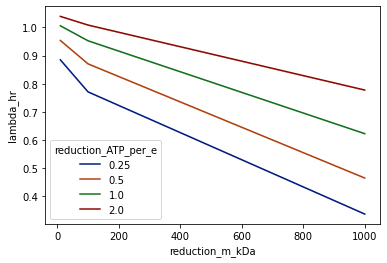

In [14]:
max_idx = res_df.groupby('reduction_m_kDa,ATP_homeostasis_m_kDa,reduction_ATP_per_e'.split(',')).lambda_hr.idxmax()
max_lambda = res_df.loc[max_idx]

sns.lineplot(data=max_lambda, x='reduction_m_kDa', y='lambda_hr', hue='reduction_ATP_per_e', palette='dark')

In [15]:
max_lambda.phi_o.values

array([0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.40000001,
       0.40000001, 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       , 0.4       , 0.4       , 0.4       , 0.4       ,
       0.4       ])